In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 20
plt.rcParams['figure.figsize'] = (12, 4)
plt.style.use("ggplot")

## Reading the dataset

In [2]:
# Column names to use
cols = ["age", "work_class", "final_weight", "education", 
        "education_num", "marital_status", "occupation", "relationship", 
        "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]

# Reading the data
df = pd.read_csv("adult.data", names = cols)
df.head()

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data Understanding

In [3]:
# Shape of the dataset
print(f"Dataset shape: contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset shape: contains 32561 rows and 15 columns.


In [4]:
# Summary Statistics
print("Summary Statistics for numerical features: ")
display(df.describe(include = [float, int]))
print("-"*100)
print("Summary Statistics for non-numerical features: ")
display(df.describe(exclude = [float, int]))

Summary Statistics for numerical features: 


,age,final_weight,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


----------------------------------------------------------------------------------------------------
Summary Statistics for non-numerical features: 


,work_class,education,marital_status,occupation,relationship,race,sex,native_country,salary
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [5]:
# Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   work_class      32561 non-null  object
 2   final_weight    32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
# Unique Values of each Feature
df.apply(pd.unique)

age               [39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 2...
work_class        [ State-gov,  Self-emp-not-inc,  Private,  Fed...
final_weight      [77516, 83311, 215646, 234721, 338409, 284582,...
education         [ Bachelors,  HS-grad,  11th,  Masters,  9th, ...
education_num     [13, 9, 7, 14, 5, 10, 12, 11, 4, 16, 15, 3, 6,...
marital_status    [ Never-married,  Married-civ-spouse,  Divorce...
occupation        [ Adm-clerical,  Exec-managerial,  Handlers-cl...
relationship      [ Not-in-family,  Husband,  Wife,  Own-child, ...
race              [ White,  Black,  Asian-Pac-Islander,  Amer-In...
sex                                                [ Male,  Female]
capital_gain      [2174, 0, 14084, 5178, 5013, 2407, 14344, 1502...
capital_loss      [0, 2042, 1408, 1902, 1573, 1887, 1719, 1762, ...
hours_per_week    [40, 13, 16, 45, 50, 80, 30, 35, 60, 20, 52, 4...
native_country    [ United-States,  Cuba,  Jamaica,  India,  ?, ...
salary                                          

#### Findings 
1. There are outliers in the dataset as can be seen from a very high discrepancies between the 75th percentile and max values in capital_gain and capital_loss column.
2. The target feature (salary) contains two unique values, "<=50K" for entries who earns less than or equal 50k and ">50k" for enries earning more than 50k.
3. There are no missing values in the dataset but there are some errors such as "?" in the 'native_country' column.
4. There are leading spaces in non-numerical columns.

## Data Preprocessing

#### Removing the Leading Spaces in the object columns

In [7]:
for col in df.columns:
    if df[col].dtype == "object":
        unique_values = df[col].unique()
        unique_values_without_spaces = [value.lstrip() for value in unique_values]
        df[col].replace(unique_values, unique_values_without_spaces, inplace=True)
        
# Checking if the leading spaces were removed
df.marital_status.unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

#### Handling Null Values
- The dataset source mentioned that "?" represents null values.

In [8]:
# Replace "?" with null values
df = df.replace("?", np.nan)

# Check for null values
df.isna().sum()

age                  0
work_class        1836
final_weight         0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
salary               0
dtype: int64

After replacing "?" with null values, we can see that there are 3 columns which contains null values in the dataset.

In [9]:
# Dropping the null values
df = df.dropna()
df.shape

(30162, 15)

Now, we have 30162 entries left after removing 2399 null values or 7% of the total entries in the dataset.

#### Handling Duplicate Entries

In [10]:
print(f"There are {df.duplicated().sum()} duplicates in the dataset.")
print("-"*140)

# Locating the duplicates
print("Duplicate Entries:")
df.loc[df.duplicated(keep = False)].sort_values(by = "final_weight")

There are 23 duplicates in the dataset.
--------------------------------------------------------------------------------------------------------------------------------------------
Duplicate Entries:


,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
28846,39,Private,30916,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
25624,39,Private,30916,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
21875,49,Private,31267,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
7920,49,Private,31267,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
22494,49,Self-emp-not-inc,43479,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
7053,49,Self-emp-not-inc,43479,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
2303,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
5104,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
17673,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [11]:
# Dropping the duplicate entries
df.drop_duplicates(inplace = True)

#### Handling Outliers

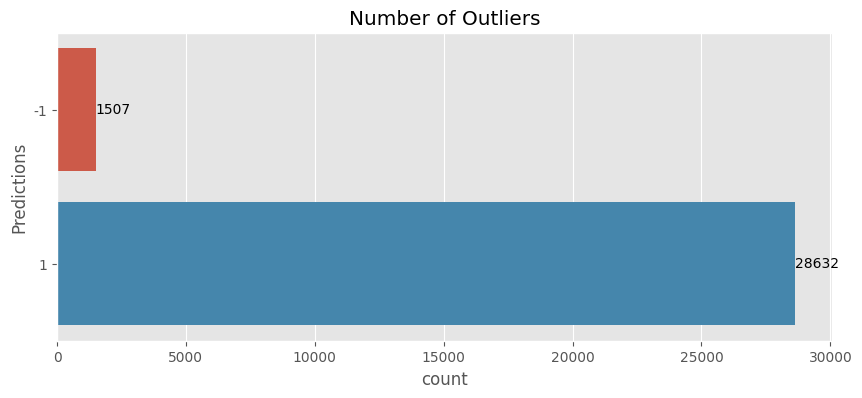

In [12]:
# Creating an IsolationForest object
isf = IsolationForest(contamination=0.05, random_state = 16)

# Creating a column to store the predictions. Isolation Forest label outliers as -1 and inliers as 1
df["Predictions"] = isf.fit_predict(df.loc[:, ["age", "final_weight", "capital_gain", "capital_loss"]].to_numpy())

# Checking the number of outliers in the dataset
plt.figure(figsize = (10, 4))
ax = sns.countplot(data = df, y = "Predictions")
ax.bar_label(ax.containers[0])
plt.title("Number of Outliers")
plt.show()

In [13]:
# Removing the outliers from the dataset
df = df.loc[df.Predictions.eq(1)]

# Dropping the 'Predictions' column
df.drop("Predictions", axis = 1, inplace = True)

#### Feature Scaling

In [14]:
columns_to_scale = ["age", "final_weight", "capital_gain", "capital_loss", "hours_per_week"]

# Creating a StandardScaler object
scaler = StandardScaler()

# Scale
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.head()

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,0.075986,State-gov,-1.116064,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,0.949665,-0.147191,-0.065737,United-States,<=50K
1,0.932654,Self-emp-not-inc,-1.056777,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,-0.227006,-0.147191,-2.342043,United-States,<=50K
2,-0.001893,Private,0.297112,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,-0.227006,-0.147191,-0.065737,United-States,<=50K
3,1.166291,Private,0.492264,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,-0.227006,-0.147191,-0.065737,United-States,<=50K
4,-0.780682,Private,1.553072,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,-0.227006,-0.147191,-0.065737,Cuba,<=50K


#### Feature Encoding

In [15]:
# Features to encode
categorical_cols = []
for col in df.columns:
    if df[col].dtype == "object" and col != "salary":
        categorical_cols.append(col)

# Performing one hot encoding to the categorical columns
df = pd.get_dummies(df, columns = categorical_cols)

# Mapping the salary labels
df.salary = df.salary.map({"<=50K": 0, ">50K": 1})

df.head()

,age,final_weight,education_num,capital_gain,capital_loss,hours_per_week,salary,work_class_Federal-gov,work_class_Local-gov,work_class_Private,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.075986,-1.116064,13,0.949665,-0.147191,-0.065737,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.932654,-1.056777,13,-0.227006,-0.147191,-2.342043,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,-0.001893,0.297112,9,-0.227006,-0.147191,-0.065737,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,1.166291,0.492264,7,-0.227006,-0.147191,-0.065737,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,-0.780682,1.553072,13,-0.227006,-0.147191,-0.065737,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Feature Selection

In [16]:
# Selecting the independent features
X = df.drop(["salary", "education_num"], axis = 1)
y = df.salary

#### Addressing Class Imbalance 
- The dataset is highly imbalance when it comes to the target feature so it is best to generate synthetic samples for the minority class (1) to balance it to create a more robust classification model.

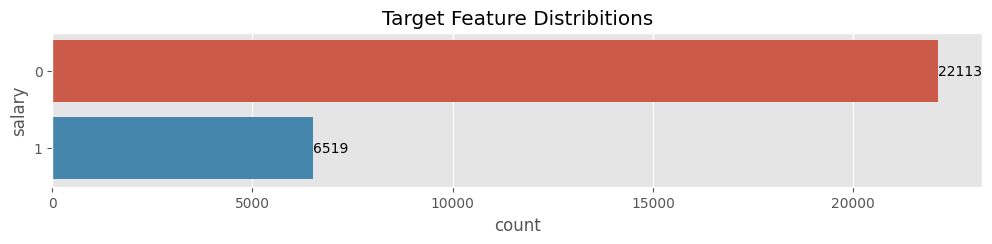

In [17]:
# Checking the distribution of the target feature (salary)
plt.figure(figsize = (12, 2))
ax = sns.countplot(y = y)
ax.bar_label(ax.containers[0])
plt.title("Target Feature Distribitions")
plt.show()

As shown from the above graph, the class labels for the target feature is highly imbalance. To address this problem, I am going to use a synthetic minority sampler called SMOTE from imblearn to create additional samples for the minority class to attain a 1:1 ratio between the class labels (0 and 1).

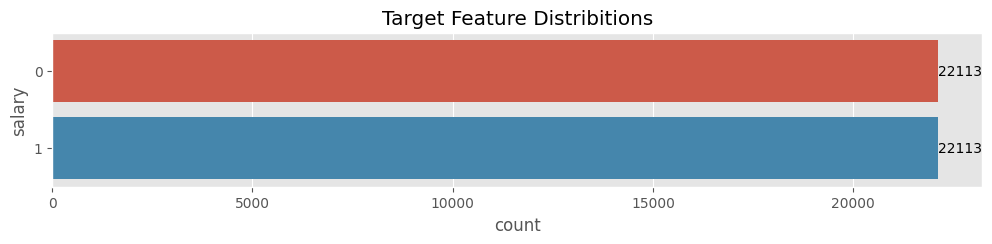

In [18]:
# Creating a synthethic minority sampler from imblearn
smote = SMOTE(random_state = 16)

# Generating synthetic samples
X_resample, y_resample = smote.fit_resample(X, y)

# Checking the new distribution of the target feature
plt.figure(figsize = (12, 2))
ax = sns.countplot(y = y_resample)
ax.bar_label(ax.containers[0])
plt.title("Target Feature Distribitions")
plt.show()

As shown in the graph, we were able to add random samples to "1", balancing the target feature to 1:1 ratio. This way, we can avoid making any biases in our predictions in the future.

#### Splitting the Dataset
- 20% of the data will be used for testing while the rest is for training the model.
- Both the original and resampled X and y dataframes will be split to compare the difference between having an imbalance and balance dataset in creating a classification model.

In [19]:
# Splitting the original X and y 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)
print(f"Shape of the original X_train and X_test: {X_train.shape, X_test.shape}")

# Splitting the resampled X and y
X_train_resample, X_test_resample, y_train_resample, y_test_resample = train_test_split(X_resample, y_resample, 
                                                                                        test_size = 0.2, random_state = 16)
print(f"Shape of the X_train_resample and X_test_resample: {X_train_resample.shape, X_test_resample.shape}")

Shape of the original X_train and X_test: ((22905, 102), (5727, 102))
Shape of the X_train_resample and X_test_resample: ((35380, 102), (8846, 102))


## Model Training and Validation

### Using HistGradientBoosting

In [20]:
def hist_model(X_train, y_train):
    model = HistGradientBoostingClassifier(random_state = 16)
    model = model.fit(X_train, y_train)
    return model

# Training using the original X and y
model = hist_model(X_train, y_train)

# Training using the ros X and y
resample_model = hist_model(X_train_resample, y_train_resample)

# Making Predictions
y_pred = model.predict(X_test) # Original df
y_pred_resample = resample_model.predict(X_test_resample) # ros df

In [21]:
# Comparing the results of the original df and ros df
print("Classification report using the original X and y:")
print(classification_report(y_test, y_pred))

print("-"*60)

print("Classification report using the ros X and y:")
print(classification_report(y_test_resample, y_pred_resample))

Classification report using the original X and y:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4447
           1       0.73      0.62      0.67      1280

    accuracy                           0.86      5727
   macro avg       0.81      0.78      0.79      5727
weighted avg       0.86      0.86      0.86      5727

------------------------------------------------------------
Classification report using the ros X and y:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      4384
           1       0.87      0.92      0.89      4462

    accuracy                           0.89      8846
   macro avg       0.89      0.89      0.89      8846
weighted avg       0.89      0.89      0.89      8846



As shown from the classification reports, the model was underperforming in classifying entries with a supposed '1' target label when trained on the original X and y. This can be proven by comparing the classification results between 0 and 1 in terms of precision, recall, and f1-score, in which classifying 0 class labels yield a much higher accuracy compared to the other class labels. On the other hand, when training our model on the ros X and y, we can observe that the difference between 0 and 1 in terms of the 3 metrics became smaller. This proved that our model became more robust as it was able to classify both labels with more than 80% accuracy. Overall, we obtained an 89% accuracy using the HistGradientBoosting Classifier when using the resampled X and y dataframes.

### Using RandomForestClassifier

In [22]:
# Creating a RandomForest object 
rf = RandomForestClassifier(random_state = 16)

# Model Training
rf.fit(X_train_resample, y_train_resample)

# Model Predictions
y_pred_resample = rf.predict(X_test_resample) 

In [23]:
# Classification Report
print("Classification report using the ros X and y:")
print(classification_report(y_test_resample, y_pred_resample))

Classification report using the ros X and y:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      4384
           1       0.88      0.92      0.90      4462

    accuracy                           0.90      8846
   macro avg       0.90      0.90      0.90      8846
weighted avg       0.90      0.90      0.90      8846



By using RandomForest, the accuracy increased from 89% to 90%, outperforming the previous model by 1% margin.

### Using XGBoost

In [24]:
# # HyperParameter Tuning
# model = XGBClassifier(random_state = 16)

# params = {
#     "n_estimators": [100,200,300,400,500],
#     "max_depth": [3,6,9],
#     "learning_rate": [0.01, 0.1],
#     "gamma": [0.01, 0.1]
    
# }
# GS = GridSearchCV(estimator = model, param_grid = params, scoring = 'accuracy', verbose = 4)
# GS.fit(X_train_resample, y_train_resample)

# best_params = GS.best_params_
# best_params_score = GS.best_score_

# print(f"Best Parameters: {best_params}")
# print(f"Score: {best_params_score}")

In [25]:
# Defining parameters to use
params = {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 400}
best_params = {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500}


# Creating an XGBClassifier object
xgb = XGBClassifier(**best_params, random_state = 16)

# Model Training
xgb.fit(X_train_resample, y_train_resample)

# Model Predictions
y_pred_resample = xgb.predict(X_test_resample) 

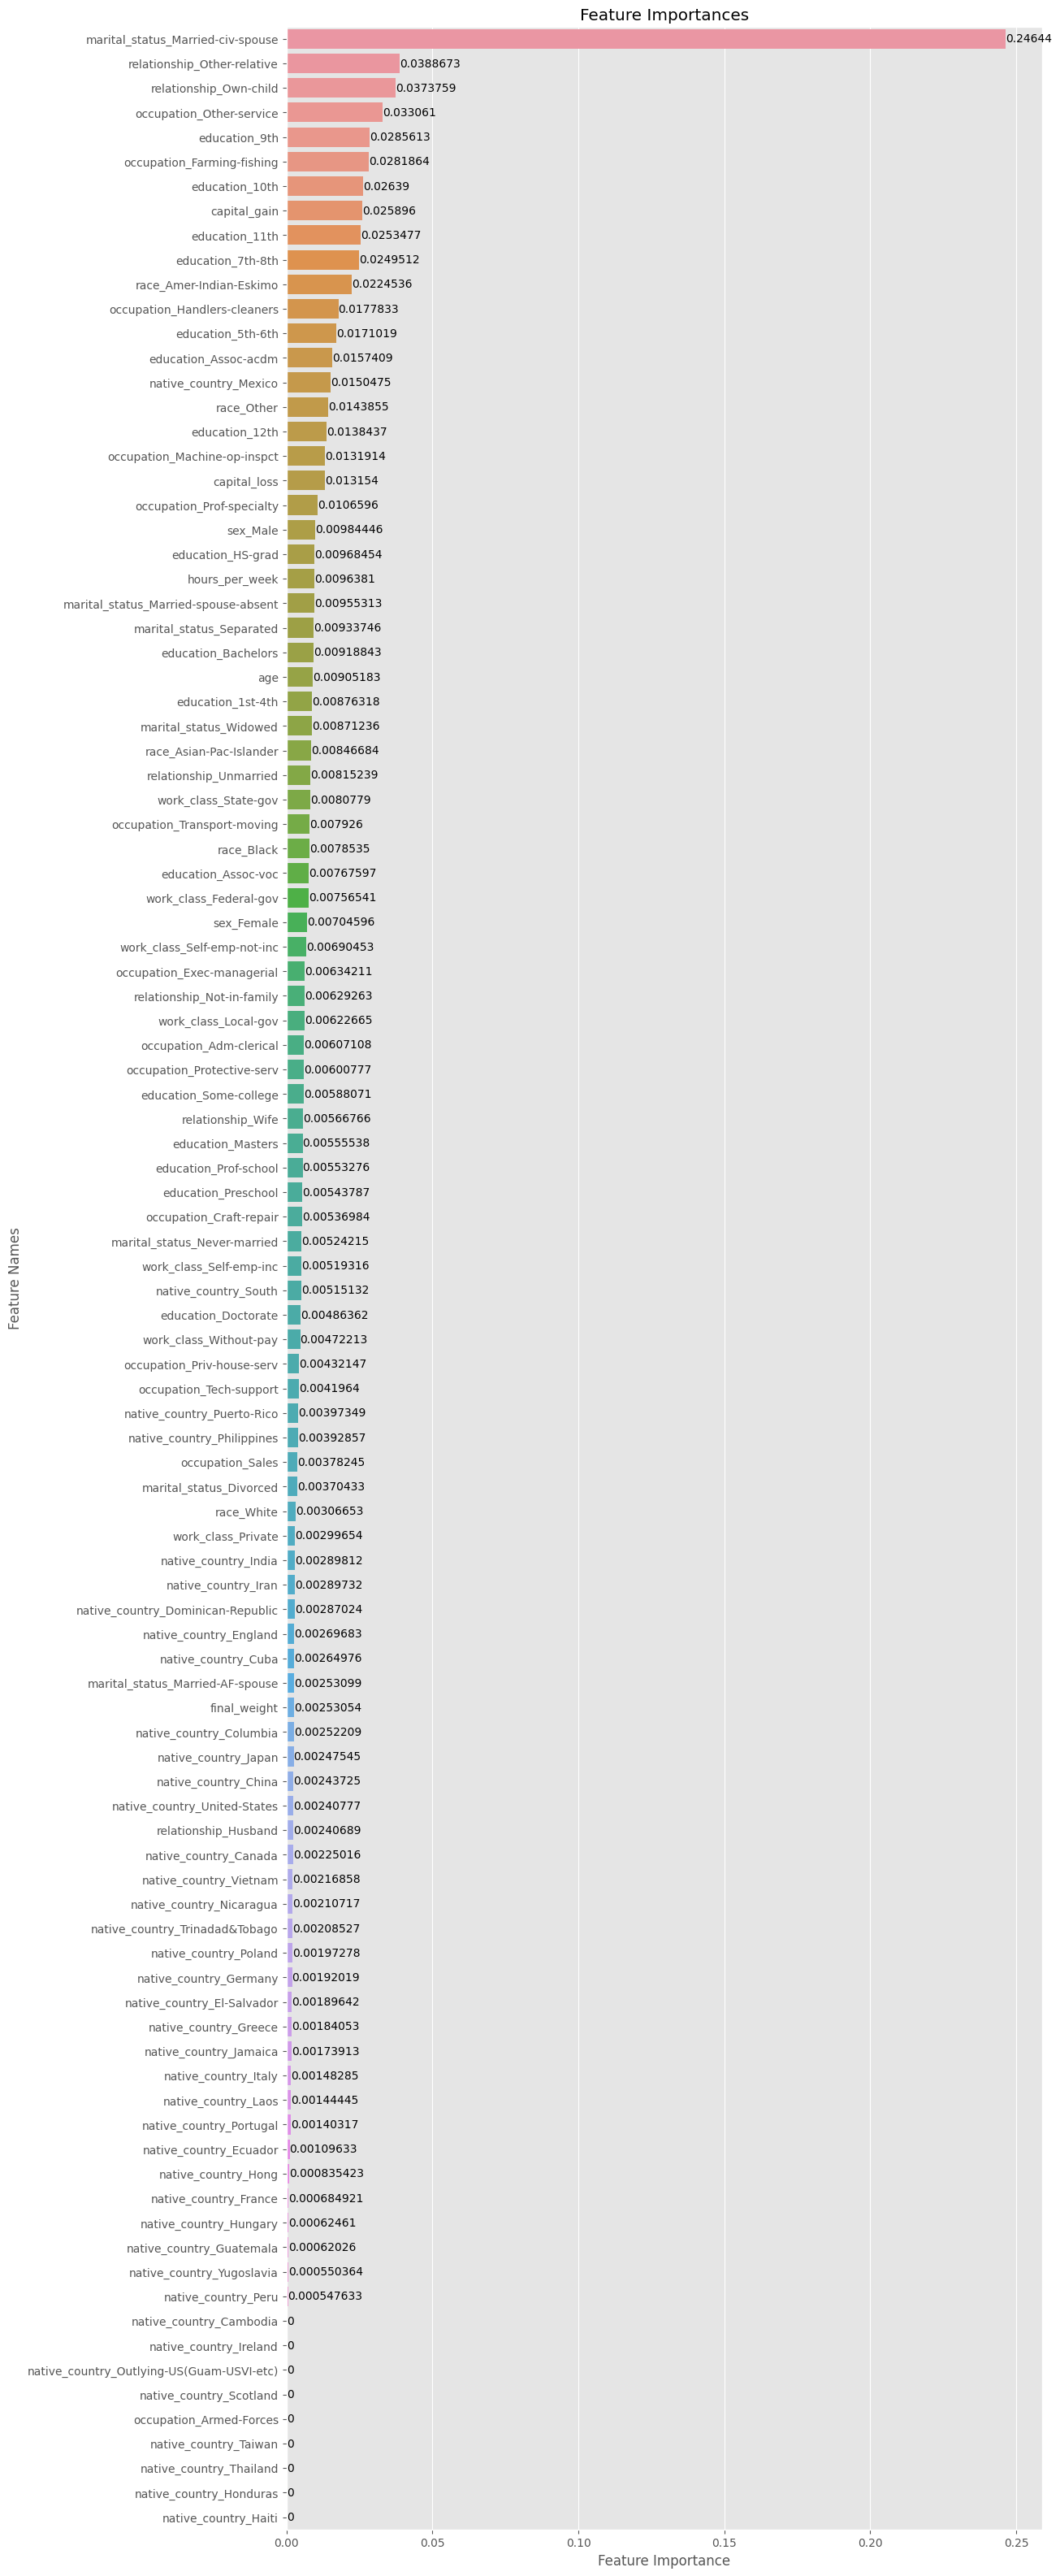

In [26]:
# Check the Feature importances
feature_names = X_train_resample.columns
feature_importance = xgb.feature_importances_

# Creating a dataframe for feature importances
feature_importances_df = pd.DataFrame({"Feature Names": feature_names, "Feature Importance": feature_importance})
feature_importances_df = feature_importances_df.sort_values(by = "Feature Importance", ascending = False)

# Plot
plt.figure(figsize = (12, 40))
ax = sns.barplot(data = feature_importances_df, x = "Feature Importance", y = "Feature Names")
ax.bar_label(ax.containers[0])
plt.title("Feature Importances")
plt.show()

In [27]:
# Classification Report
print("Classification report using the ros X and y:")
print(classification_report(y_test_resample, y_pred_resample))

Classification report using the ros X and y:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4384
           1       0.91      0.91      0.91      4462

    accuracy                           0.91      8846
   macro avg       0.91      0.91      0.91      8846
weighted avg       0.91      0.91      0.91      8846



By using XGBoost, the accuracy increased from 90% to 91%, outperforming the previous model by 1% margin.